In [1]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)
from utils import *
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pickle import dump, load

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Carregar treino
X = []
y = []

dirs = ['audios\\amostras_treino', 'audios\\minhas_treino']
label = 0
for dir in dirs:
    files = os.listdir(dir)
    for name_file in files:
        path = os.path.join(dir, name_file)
        #coefs = get_mfcc_coefs(path)
        coefs = get_mfcc_coefs(path)
        X.append(coefs)
        y.append(label)
    label=1

X = np.array(X)
y = np.array(y)
y_c = to_categorical(y, 2)

print(X.shape)
print(y.shape)
print(y_c.shape)

(90, 3600)
(90,)
(90, 2)


In [3]:
# Scaler
scaler = StandardScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)
dump(scaler, open('scaler.pkl', 'wb'))

In [4]:
# Carregar teste
X_test = []
y_test = []

dirs = ['audios\\amostras_teste', 'audios\\minha_teste']
label = 0
for dir in dirs:
    files = os.listdir(dir)
    for name_file in files:
        path = os.path.join(dir, name_file)
        #coefs = get_mfcc_coefs(path)
        coefs = get_mfcc_coefs(path)
        X_test.append(coefs)
        y_test.append(label)
    label=1

X_test = np.array(X_test)
y_test = np.array(y_test)
y_c_test = to_categorical(y_test, 2)

X_test = scaler.transform(X_test)

print(X_test.shape)
print(y_test.shape)
print(y_c_test.shape)

(30, 3600)
(30,)
(30, 2)


In [5]:
# Carregar validacao
X_validacao = []
y_validacao = []

dirs = ['audios\\amostras_validacao', 'audios\\minhas_validacao']
label = 0
for dir in dirs:
    files = os.listdir(dir)
    for name_file in files:
        path = os.path.join(dir, name_file)
        #coefs = get_mfcc_coefs(path)
        coefs = get_mfcc_coefs(path)
        X_validacao.append(coefs)
        y_validacao.append(label)
    label=1

X_validacao = np.array(X_validacao)
y_validacao = np.array(y_validacao)
y_c_validacao = to_categorical(y_validacao, 2)

X_validacao = scaler.transform(X_validacao)

print(X_validacao.shape)
print(y_validacao.shape)
print(y_c_validacao.shape)

(24, 3600)
(24,)
(24, 2)


In [6]:
# Folds para validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

In [7]:
# Parada antecipada
early_stopping = callbacks.EarlyStopping(
    #min_delta=0.001,
    min_delta=0,
    patience=15,
    monitor='val_loss',
    restore_best_weights=True
)

#Otimizador
opt = keras.optimizers.Adam(learning_rate=0.001)

In [8]:
# Treino com validação cruzada para ajuste dos parâmetros
fold = 0
scores_train = []
scores_val = []
histories_df = []
imgs_train = []
imgs_val = []
for train, val in skf.split(X, y):
    fold = fold+1
    print(f'******************************************** FOLD {fold} *****************************************************************')
    X_train = X[train]
    X_val = X[val]
    y_c_train = y_c[train]
    y_c_val = y_c[val]

    # Criar o modelo
    model = keras.Sequential([
        layers.InputLayer(input_shape=[X_train.shape[1]]),
        layers.BatchNormalization(),
        #layers.Dense(4501, activation='tanh'),
        layers.Dense(7201, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(2, activation='softmax')
    ])

    # Propriedades do modelo
    model.compile(
        loss='categorical_crossentropy',
        optimizer=opt,
        #optimizer='adam',
        metrics=['accuracy']
    )

    # Treinar o modelo
    history = model.fit(
        X_train, y_c_train,
        validation_data=(X_val, y_c_val),
        batch_size=16,
        epochs=100,
        callbacks=[early_stopping],
        verbose=0,
        #shuffle=True
    )
    histories_df.append(pd.DataFrame(history.history))
    score_train = model.evaluate(X_train, y_c_train)
    scores_train.append(score_train)
    score_val = model.evaluate(X_val, y_c_val)
    scores_val.append(score_val)
    
    #pred_train = model.predict(X_train)
    #y_real_train = np.argmax(y_c_train, -1)
    #y_pred_train = np.argmax(pred_train, -1)
    #print('TREINO: ')
    #print(classification_report(y_real_train, y_pred_train))
    
    #pred_val = model.predict(X_val)
    #y_real_val = np.argmax(y_c_val, -1)
    #y_pred_val = np.argmax(pred_val, -1)
    #print('VALIDACAO: ')
    #print(classification_report(y_real_val, y_pred_val))
    
    print('--------------------------------------------------------------------------------------------------------')


******************************************** FOLD 1 *****************************************************************
1/1 [==============================] - 0s 52ms/step - loss: 7.8606e-04 - accuracy: 1.0000
--------------------------------------------------------------------------------------------------------
******************************************** FOLD 2 *****************************************************************
1/1 [==============================] - 0s 33ms/step - loss: 2.5166e-07 - accuracy: 1.0000
--------------------------------------------------------------------------------------------------------
******************************************** FOLD 3 *****************************************************************
1/1 [==============================] - 0s 29ms/step - loss: 1.7881e-07 - accuracy: 1.0000
--------------------------------------------------------------------------------------------------------
******************************************** FOLD 4 *********

In [9]:
#Scores do treino
scores_train = np.array(scores_train)
scores_val = np.array(scores_val)

mean_train = (scores_train[:,1]).mean()
std_train = (scores_train[:,1]).std()
mean_val = (scores_val[:,1]).mean()
std_val = (scores_val[:,1]).std()

print('TREINO (Media | Std) : {} | {}'.format(mean_train, std_train))
print('VALIDACAO (Media | Std) : {} | {}'.format(mean_val, std_val))

TREINO (Media | Std) : 1.0 | 0.0
VALIDACAO (Media | Std) : 1.0 | 0.0


<AxesSubplot:title={'center':'Perda no primeiro fold'}, xlabel='Época'>

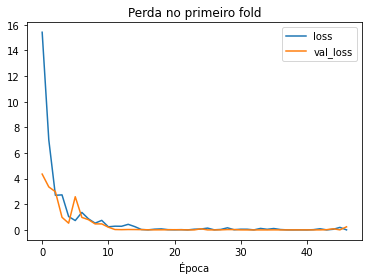

In [10]:
# Loss no primeiro fold
histories_df[0][['loss', 'val_loss']].plot(xlabel='Época', title='Perda no primeiro fold')

<AxesSubplot:title={'center':'Acurácia no primeiro fold'}, xlabel='Época'>

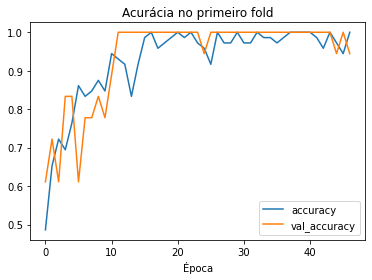

In [11]:
# Acuracia no primeiro fold
histories_df[0][['accuracy', 'val_accuracy']].plot(xlabel='Época', title='Acurácia no primeiro fold')

<AxesSubplot:title={'center':'Perda no segundo fold'}, xlabel='Época'>

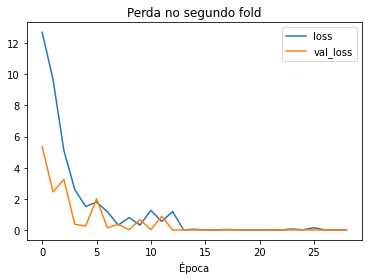

In [12]:
# Loss no segundo fold
histories_df[1][['loss', 'val_loss']].plot(xlabel='Época', title='Perda no segundo fold')

<AxesSubplot:title={'center':'Acurácia no segundo fold'}, xlabel='Época'>

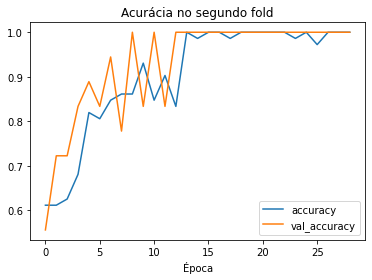

In [13]:
# Acuracia no segundo fold
histories_df[1][['accuracy', 'val_accuracy']].plot(xlabel='Época', title='Acurácia no segundo fold')

<AxesSubplot:title={'center':'Perda no terceiro fold'}, xlabel='Época'>

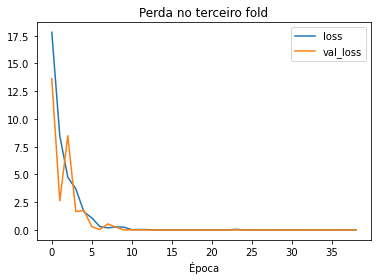

In [14]:
# Loss no terceiro fold
histories_df[2][['loss', 'val_loss']].plot(xlabel='Época', title='Perda no terceiro fold')

<AxesSubplot:title={'center':'Acurácia no terceiro fold'}, xlabel='Época'>

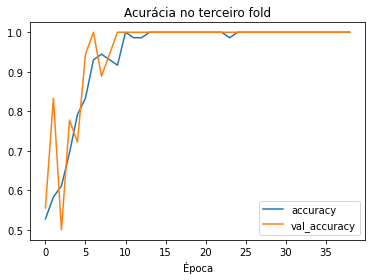

In [15]:
# Acuracia no terceiro fold
histories_df[2][['accuracy', 'val_accuracy']].plot(xlabel='Época', title='Acurácia no terceiro fold')

<AxesSubplot:title={'center':'Perda no quarto fold'}, xlabel='Época'>

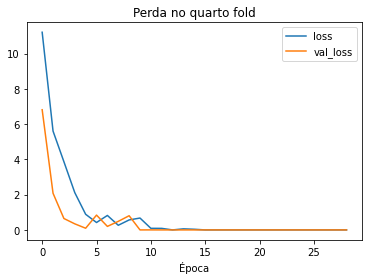

In [16]:
# Loss no quarto fold
histories_df[3][['loss', 'val_loss']].plot(xlabel='Época', title='Perda no quarto fold')

<AxesSubplot:title={'center':'Acurácia no quarto fold'}, xlabel='Época'>

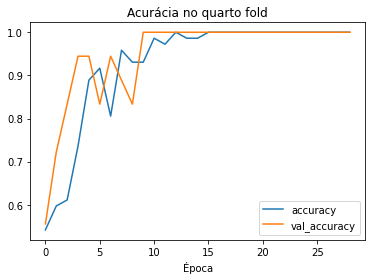

In [17]:
# Acuracia no quarto fold
histories_df[3][['accuracy', 'val_accuracy']].plot(xlabel='Época', title='Acurácia no quarto fold')

<AxesSubplot:title={'center':'Perda no quinto fold'}, xlabel='Época'>

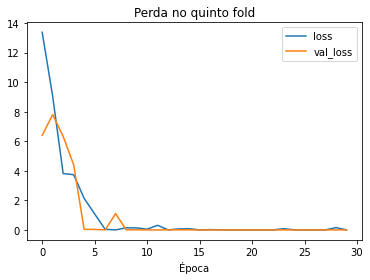

In [18]:
# Loss no quinto fold
histories_df[4][['loss', 'val_loss']].plot(xlabel='Época', title='Perda no quinto fold')

<AxesSubplot:title={'center':'Acurácia no quinto fold'}, xlabel='Época'>

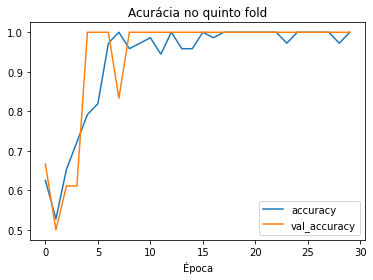

In [19]:
# Acuracia no quinto fold
histories_df[4][['accuracy', 'val_accuracy']].plot(xlabel='Época', title='Acurácia no quinto fold')

In [20]:
# Treino principal
model_final = keras.Sequential([
        layers.InputLayer(input_shape=[X_train.shape[1]]),
        layers.BatchNormalization(),
        #layers.Dense(4501, activation='tanh'),
        layers.Dense(7201, activation='tanh'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(2, activation='softmax')
    ])

# Propriedades do modelo
model_final.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    #optimizer='adam',
    metrics=['accuracy']
)

# Treinar o modelo
history = model_final.fit(
    X, y_c,
    validation_data=(X_validacao, y_c_validacao),
    batch_size=16,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1,
    #shuffle=True
 )

Epoch 1/100
6/6 [==============================] - 2s 193ms/step - loss: 9.5397 - accuracy: 0.6000 - val_loss: 4.7809 - val_accuracy: 0.6250
Epoch 2/100
6/6 [==============================] - 1s 200ms/step - loss: 3.4563 - accuracy: 0.6222 - val_loss: 0.0362 - val_accuracy: 0.9583
Epoch 3/100
6/6 [==============================] - 1s 152ms/step - loss: 2.1911 - accuracy: 0.7556 - val_loss: 0.8086 - val_accuracy: 0.8750
Epoch 4/100
6/6 [==============================] - 1s 155ms/step - loss: 0.4030 - accuracy: 0.9111 - val_loss: 1.9030 - val_accuracy: 0.7917
Epoch 5/100
6/6 [==============================] - 1s 166ms/step - loss: 0.3325 - accuracy: 0.9333 - val_loss: 0.7522 - val_accuracy: 0.8333
Epoch 6/100
6/6 [==============================] - 1s 153ms/step - loss: 0.1017 - accuracy: 0.9889 - val_loss: 0.7258 - val_accuracy: 0.9583
Epoch 7/100
6/6 [==============================] - 1s 156ms/step - loss: 0.1175 - accuracy: 0.9556 - val_loss: 0.1608 - val_accuracy: 0.9583
Epoch 8/100
6

In [21]:
# Avaliação no grupo de teste
model_final.evaluate(X_test, y_c_test)

1/1 [==============================] - 0s 41ms/step - loss: 0.4715 - accuracy: 0.9667


[0.4714655578136444, 0.9666666388511658]

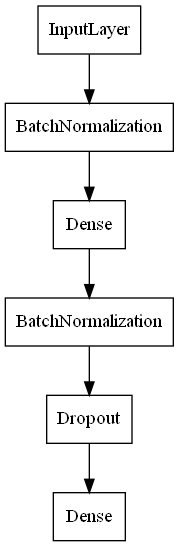

In [22]:
# Estrutura da rede neural
plot_model(model_final, to_file='model_plot.png', show_shapes=False, show_layer_names=False)

In [23]:
# Estatísticas do teste
pred_test = model_final.predict(X_test)
y_real_test = np.argmax(y_c_test, -1)
y_pred_test = np.argmax(pred_test, -1)
print(classification_report(y_real_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



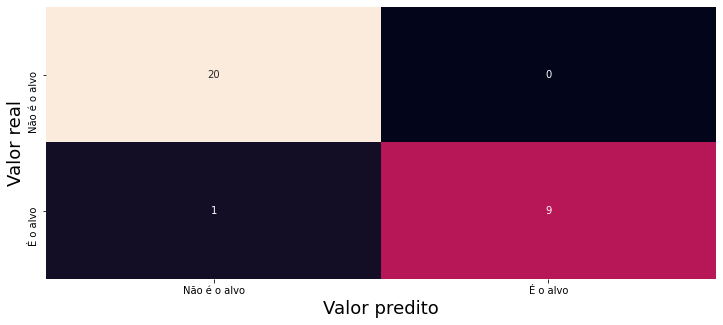

In [24]:
# Matriz de confusão
plt.subplots(figsize=(12,5))
cmat = confusion_matrix(y_real_test, y_pred_test)

axis_label = ['Não é o alvo', 'É o alvo']

sns.heatmap(cmat, annot=True, cbar=False, xticklabels=axis_label, yticklabels=axis_label);
plt.xlabel('Valor predito', fontsize='18');
plt.ylabel('Valor real', fontsize='18');


In [25]:
y_pred_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

In [26]:
#Salvar modelo
#model_final.save('modelo_mfcc')